# MAE Reconstruction Demo

This notebook loads a pretrained MAE checkpoint and visualizes qualitative reconstructions:

- **Original** image
- **Masked input** (visible patches kept, masked patches zeroed)
- **Reconstruction** (MAE output)

Notes:
- The training pipeline normalizes images (ImageNet mean/std). Reconstructions are predicted in that normalized space, so we **denormalize for visualization**.
- Works for both `cifar100` and `stl10` checkpoints as long as the config matches the checkpoint.


In [1]:
from pathlib import Path
import sys

# Make `import src...` work from notebooks/
PROJECT_ROOT = Path.cwd().resolve().parents[0]
if (PROJECT_ROOT / "src").exists():
    sys.path.insert(0, str(PROJECT_ROOT))
else:
    # If executed from elsewhere, change this to your repo path.
    raise RuntimeError("Run this notebook from <repo>/notebooks so PROJECT_ROOT points to the repo root")

import torch
import yaml
import matplotlib.pyplot as plt

from src.models.vit_encoder import ViTEncoder
from src.models.mae_decoder import MAEDecoder
from src.models.mae import MAEModel
from src.data.factory import get_dataloader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [2]:
# Example:
ckpt_path = PROJECT_ROOT / "experiments/mae_pretrained/mae_stl10_vit_tiny_img224_p16_mask90_dec4.pth"
cfg_path  = PROJECT_ROOT / "configs/pretraining/stl10/mae_vit_tiny_stl10_mask90_dec4.yaml"
assert ckpt_path.exists(), f"Missing checkpoint: {ckpt_path}"
assert cfg_path.exists(), f"Missing config: {cfg_path}"

print("Checkpoint:", ckpt_path)
print("Config:", cfg_path)

Checkpoint: /data/vedant/ESE5460/MAE-unoffical-implementation/experiments/mae_pretrained/mae_stl10_vit_tiny_img224_p16_mask90_dec4.pth
Config: /data/vedant/ESE5460/MAE-unoffical-implementation/configs/pretraining/stl10/mae_vit_tiny_stl10_mask90_dec4.yaml


In [3]:
# Imagenet normalization used by the dataloader
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def denormalize(imgs: torch.Tensor) -> torch.Tensor:
    """imgs: (B,3,H,W) normalized -> (B,3,H,W) in [0,1] approx."""
    mean = torch.tensor(IMAGENET_MEAN, device=imgs.device).view(1, 3, 1, 1)
    std = torch.tensor(IMAGENET_STD, device=imgs.device).view(1, 3, 1, 1)
    out = imgs * std + mean
    return out.clamp(0.0, 1.0)


def patchify(imgs: torch.Tensor, patch_size: int) -> torch.Tensor:
    """(B,3,H,W) -> (B, N, 3*P*P)"""
    B, C, H, W = imgs.shape
    assert H % patch_size == 0 and W % patch_size == 0
    h = H // patch_size
    w = W // patch_size
    x = imgs.reshape(B, C, h, patch_size, w, patch_size)
    x = x.permute(0, 2, 4, 3, 5, 1).contiguous()
    patches = x.reshape(B, h * w, patch_size * patch_size * C)
    return patches


def unpatchify(patches: torch.Tensor, patch_size: int, img_size: int) -> torch.Tensor:
    """(B, N, 3*P*P) -> (B,3,H,W)"""
    B, N, D = patches.shape
    h = img_size // patch_size
    w = img_size // patch_size
    assert N == h * w
    assert D == 3 * patch_size * patch_size
    x = patches.reshape(B, h, w, patch_size, patch_size, 3)
    x = x.permute(0, 5, 1, 3, 2, 4).contiguous()
    imgs = x.reshape(B, 3, img_size, img_size)
    return imgs


def apply_patch_mask(imgs: torch.Tensor, mask: torch.Tensor, patch_size: int) -> torch.Tensor:
    """Zero out masked patches in image space.
    imgs: (B,3,H,W), mask: (B,N) where 1=masked, 0=visible.
    """
    B, C, H, W = imgs.shape
    patches = patchify(imgs, patch_size)  # (B,N,D)
    patches = patches * (1.0 - mask).unsqueeze(-1)
    return unpatchify(patches, patch_size, img_size=H)




def show_triplets(orig: torch.Tensor, masked: torch.Tensor, recon: torch.Tensor, n: int = 12, title: str = "", save_fig: bool = False):
    """Display up to n samples arranged as columns with 3 rows: original/masked/recon."""
    orig = orig.detach().cpu()
    masked = masked.detach().cpu()
    recon = recon.detach().cpu()

    n = min(n, orig.shape[0])
    fig, axes = plt.subplots(nrows=3, ncols=n, figsize=(2 * n, 6))
    if n == 1:
        axes = axes.reshape(3, 1)

    row_titles = ["Original", "Masked", "Reconstruction"]
    for col in range(n):
        for row, img in enumerate([orig[col], masked[col], recon[col]]):
            ax = axes[row, col]
            ax.imshow(img.permute(1, 2, 0))
            ax.axis("off")
            if col == 0:
                ax.set_ylabel(row_titles[row], rotation=90, labelpad=10, fontsize=10)

    if title:
        fig.suptitle(title)
    plt.tight_layout()
    if save_fig:
        plt.savefig(PROJECT_ROOT / "notebooks" / "mae_reconstruction.png", dpi=500)
    plt.show()


In [4]:
with open(cfg_path, "r") as f:
    cfg = yaml.safe_load(f)

cfg

{'dataset': 'stl10',
 'data_root': 'data',
 'img_size': 224,
 'patch_size': 16,
 'embed_dim': 192,
 'encoder_depth': 12,
 'encoder_heads': 3,
 'encoder_mlp_ratio': 4.0,
 'dropout': 0.0,
 'decoder_dim': 96,
 'decoder_depth': 4,
 'decoder_heads': 3,
 'decoder_mlp_ratio': 4.0,
 'mask_ratio': 0.9,
 'batch_size': 1024,
 'epochs': 100,
 'lr': 0.0006,
 'min_lr': 0.0,
 'warmup_epochs': 10,
 'weight_decay': 0.05,
 'amp': True,
 'grad_accum_steps': 1,
 'num_workers': 12,
 'log_interval': 10,
 'output_dir': 'experiments/mae_pretrained',
 'seed': 42,
 'norm_pix_loss': True,
 'use_wandb': True,
 'wandb_project': 'mae-compact',
 'wandb_run_name': 'mae_vit_tiny_stl10_m90_d4',
 'wandb_tags': ['pretrain', 'vit_tiny', 'stl10', 'mask90', 'dec4'],
 'wandb_mode': 'offline'}

In [5]:
def build_mae_from_cfg(cfg: dict) -> MAEModel:
    encoder = ViTEncoder(
        img_size=int(cfg["img_size"]),
        patch_size=int(cfg["patch_size"]),
        in_chans=3,
        embed_dim=int(cfg["embed_dim"]),
        depth=int(cfg["encoder_depth"]),
        num_heads=int(cfg["encoder_heads"]),
        mlp_ratio=float(cfg["encoder_mlp_ratio"]),
        dropout=float(cfg.get("dropout", 0.0)),
    )
    decoder = MAEDecoder(
        embed_dim=int(cfg["embed_dim"]),
        decoder_dim=int(cfg["decoder_dim"]),
        num_patches=(int(cfg["img_size"]) // int(cfg["patch_size"])) ** 2,
        patch_size=int(cfg["patch_size"]),
        depth=int(cfg["decoder_depth"]),
        num_heads=int(cfg["decoder_heads"]),
        mlp_ratio=float(cfg["decoder_mlp_ratio"]),
        dropout=float(cfg.get("dropout", 0.0)),
    )
    mae = MAEModel(encoder=encoder, decoder=decoder, mask_ratio=float(cfg["mask_ratio"]))
    return mae


mae = build_mae_from_cfg(cfg)
ckpt = torch.load(ckpt_path, map_location="cpu")
state = ckpt.get("model_state", ckpt)

missing, unexpected = mae.load_state_dict(state, strict=False)
print("missing keys:", len(missing))
print("unexpected keys:", len(unexpected))

mae = mae.to(DEVICE)
mae.eval()

print("Loaded MAE on", DEVICE)

/home/vedant/miniconda3/envs/mae-compact/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/tmp/ipykernel_2977189/3314917731.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_on

missing keys: 0
unexpected keys: 0
Loaded MAE on cuda


In [6]:
# Load a small batch (supervised mode yields (img,label), but we ignore labels here)
loader = get_dataloader(
    dataset_name=cfg["dataset"],
    split="test",
    batch_size=16,
    num_workers=0,
    is_pretrain=False,
    data_root=cfg.get("data_root", "data"),
    img_size=int(cfg["img_size"]),
)

batch = next(iter(loader))
imgs = batch[0] if isinstance(batch, (tuple, list)) else batch
imgs = imgs.to(DEVICE)

imgs.shape

Files already downloaded and verified


torch.Size([16, 3, 224, 224])

Best-k masked MSE: [0.42683205008506775, 0.4685606062412262, 0.6680101752281189, 0.727847158908844, 0.7750114798545837, 0.8409599661827087, 0.8637166619300842, 1.073167324066162, 1.075057864189148, 1.3141820430755615, 1.3476797342300415, 1.374537467956543]


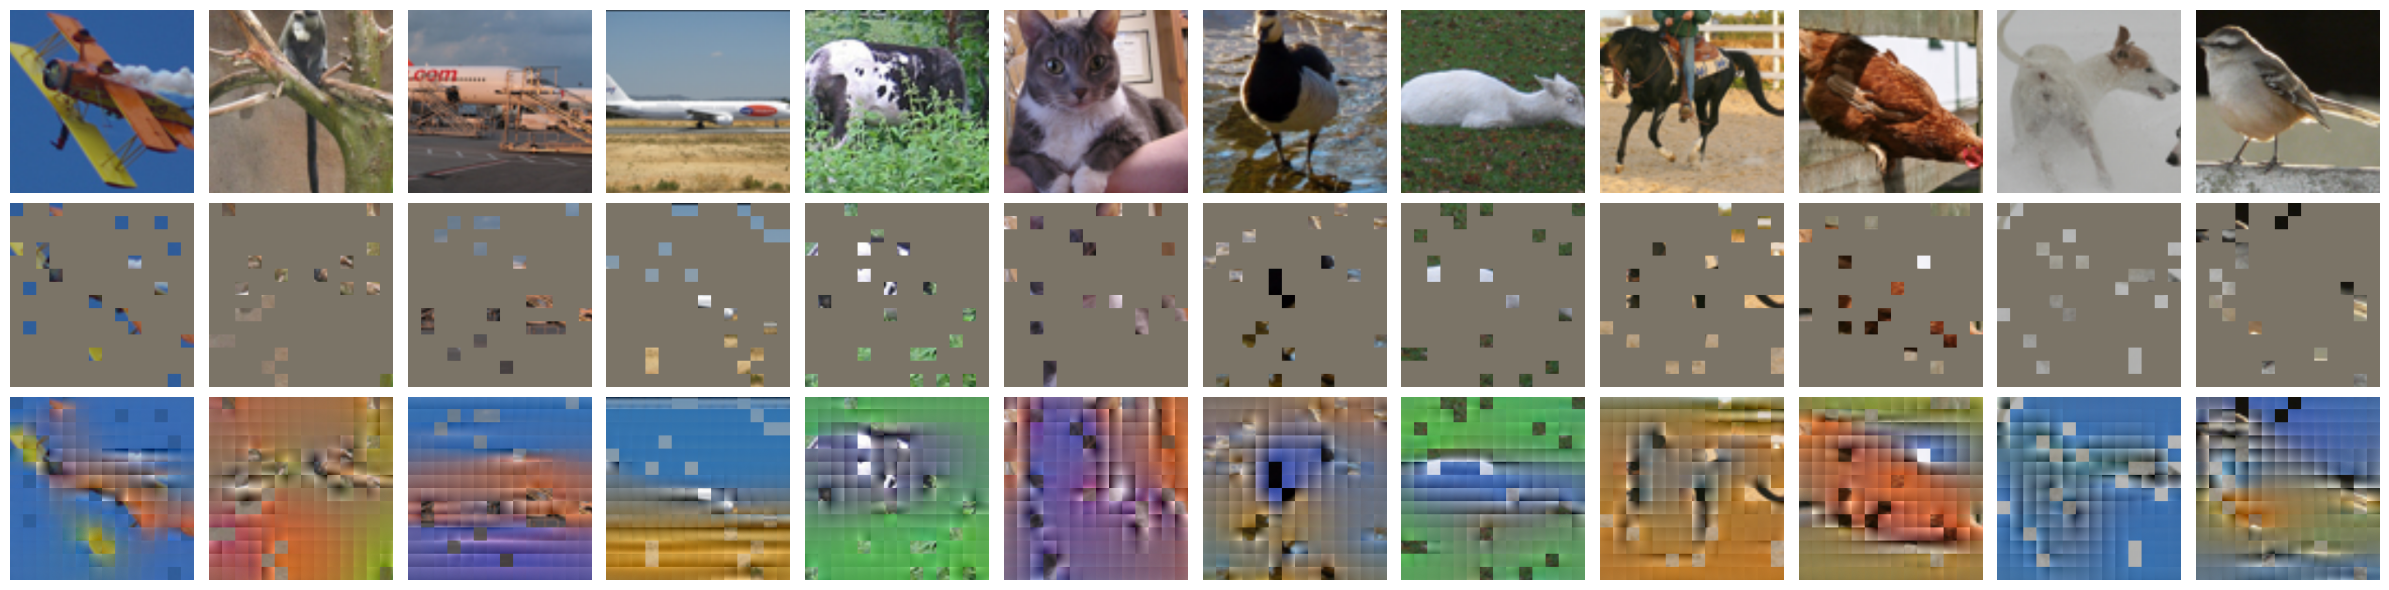

In [7]:
patch_size = int(cfg["patch_size"])
img_size = int(cfg["img_size"])

with torch.no_grad():
    with torch.autocast(device_type=DEVICE.type, dtype=torch.float16, enabled=(DEVICE.type == "cuda")):
        pred_patches, mask = mae(imgs)

# IMPORTANT:
# MAE is trained with the reconstruction loss applied to MASKED patches only.
# Predictions for VISIBLE patches are not trained to match the input and may look like noise.
# For the usual qualitative visualization, we form a composite:
#   - visible patches: from the original image
#   - masked patches: from the model prediction

target_patches = patchify(imgs, patch_size=patch_size)  # (B,N,3*P*P) normalized
recon_patches = pred_patches * mask.unsqueeze(-1) + target_patches * (1.0 - mask).unsqueeze(-1)

recon = unpatchify(recon_patches, patch_size=patch_size, img_size=img_size)
masked = apply_patch_mask(imgs, mask, patch_size=patch_size)

orig_vis = denormalize(imgs)
masked_vis = denormalize(masked)
recon_vis = denormalize(recon)

# Compute per-sample masked reconstruction error (MSE over masked patches only)
# This matches the MAE training objective and is a good way to pick "best" qualitative examples.
per_patch_mse = (pred_patches.float() - target_patches.float()).pow(2).mean(dim=-1)  # (B,N)
masked_mse = (per_patch_mse * mask).sum(dim=1) / mask.sum(dim=1).clamp_min(1.0)  # (B,)

best_k = 12
best_idx = torch.argsort(masked_mse)[:best_k]
print("Best-k masked MSE:", masked_mse[best_idx].detach().cpu().tolist())

orig_vis_best = orig_vis[best_idx]
masked_vis_best = masked_vis[best_idx]
recon_vis_best = recon_vis[best_idx]

show_triplets(
    orig_vis_best,
    masked_vis_best,
    recon_vis_best,
    n=best_k,
    # title=f"{cfg['dataset']} | mask={cfg['mask_ratio']} | dec_depth={cfg['decoder_depth']} (best masked-MSE examples)",
    save_fig=True
)


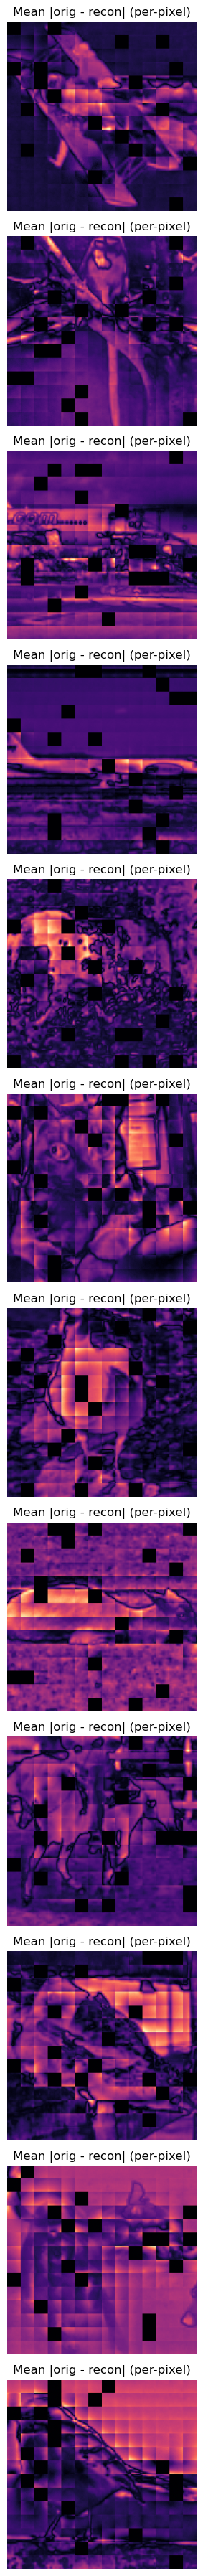

In [8]:
# Optional: visualize absolute error map (in pixel space)
err = (orig_vis_best - recon_vis_best).abs().mean(dim=1, keepdim=True)  # (B,1,H,W)

n = orig_vis_best.shape[0]
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(5, 3 * n))
if n == 1:
    axes = [axes]

for i in range(n):
    axes[i].imshow(err[i, 0].cpu(), cmap="magma")
    axes[i].axis("off")
    axes[i].set_title("Mean |orig - recon| (per-pixel)")

plt.tight_layout()
plt.show()